In [1]:
import warnings; 
warnings.simplefilter('ignore')
from __future__ import print_function
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import timeit
import random

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay



In [3]:
# Run parameters
seed=679131719
#Shuffle images
shuffle_all=True


In [4]:
num_epochs=15
batch_size = 256
test_batch_size = 256
num_classes = 10

In [5]:
torch.manual_seed(seed)
img_size = [28,28]
shuffle_order =  torch.randperm(np.prod(img_size))

In [6]:
def shuffle_to_order(order, lst):
    mst=lst[order]
    return(mst)



def restore_order(order):
    restored_order = np.zeros(len(order), dtype=int)
    for ndx,elm in enumerate(order):
        restored_order[elm] = ndx
    return(torch.from_numpy(restored_order))

In [7]:
restored_order = restore_order(shuffle_order)

In [8]:
def shuffle(order, mat):
    if shuffle_all:
        shp=mat.shape
        mmat=mat.clone().reshape(np.prod(shp))
        mmat=shuffle_to_order(order, mmat)
        return(mmat.reshape(tuple(i for i in shp)))
    return(mat)

    

In [9]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnistfiles/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Lambda(lambda x: shuffle(shuffle_order, x)),
                               torchvision.transforms.Lambda(lambda x: x.expand(3, -1, -1)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnistfiles/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Lambda(lambda x: shuffle(shuffle_order, x)),
                               torchvision.transforms.Lambda(lambda x: x.expand(3, -1, -1)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=test_batch_size, shuffle=True)

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

<Figure size 640x480 with 0 Axes>

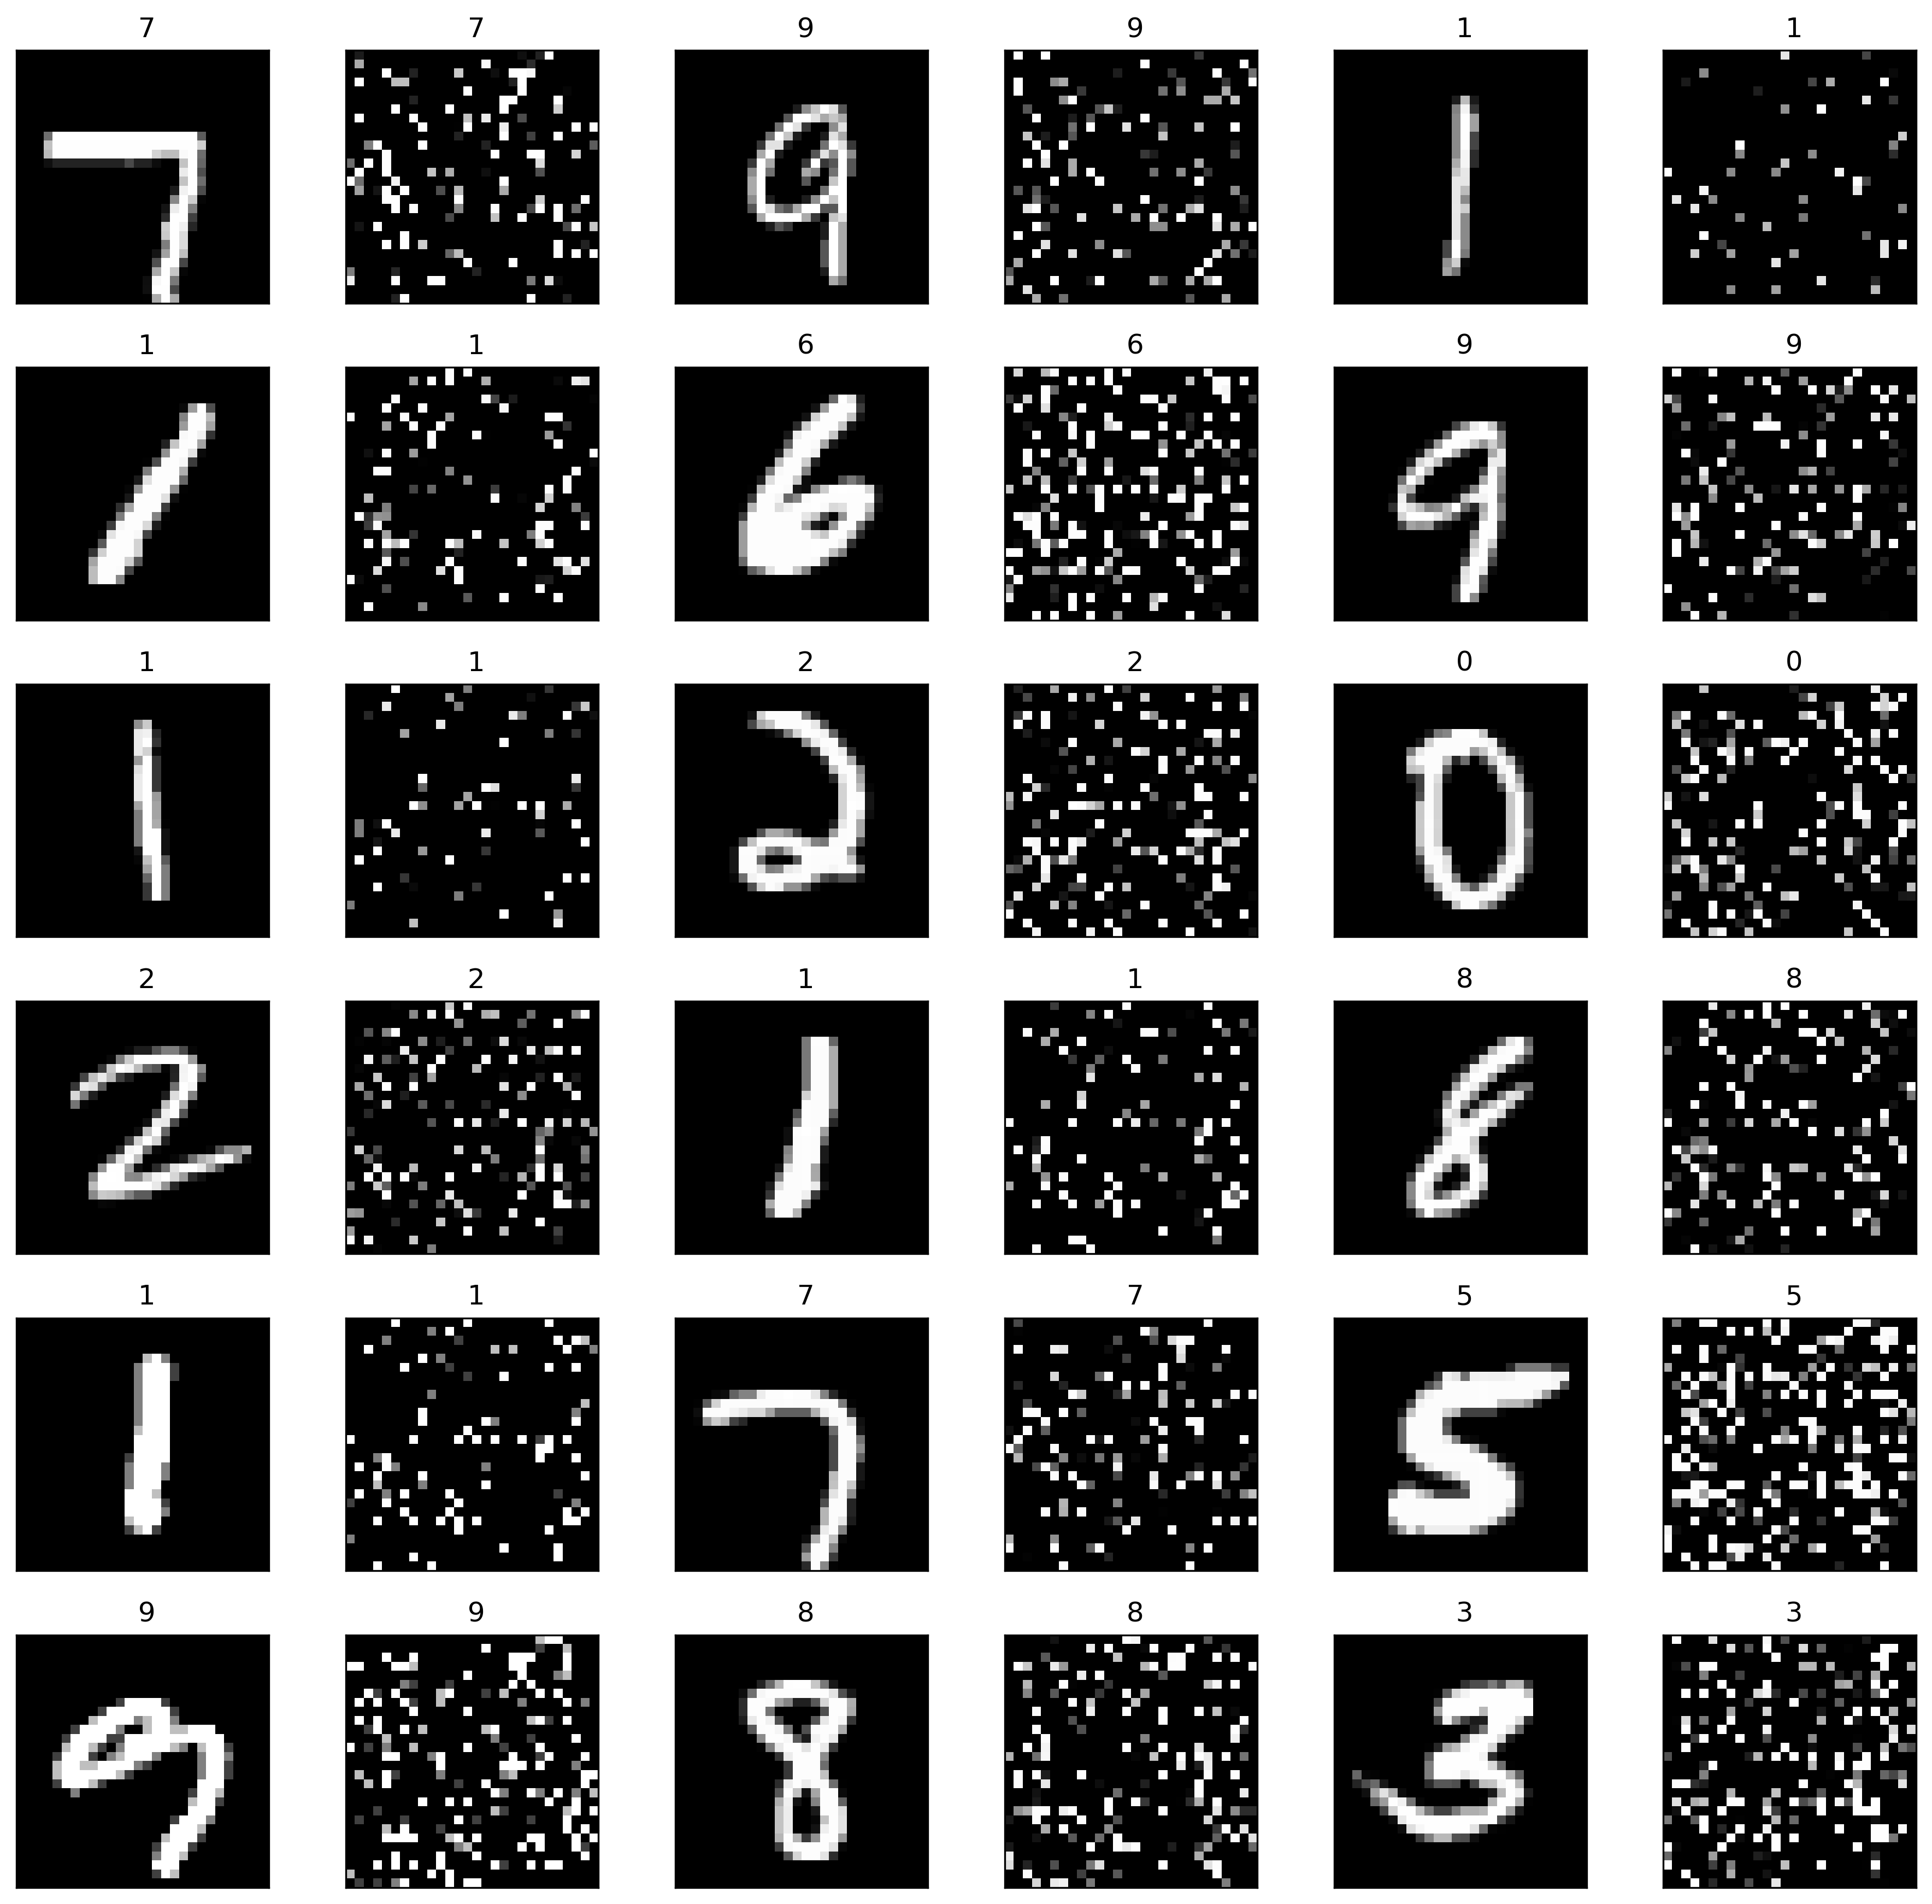

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
matplotlib.use('agg')

def display_img_at(img,lbl,l,w,loc):
    plt.subplot(l,w,loc)
    plt.tight_layout()
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title(" {}".format(lbl))
    plt.xticks([])
    plt.yticks([])
    

%matplotlib inline
fig=plt.figure()
figure(num=None, figsize=(12, 12), dpi=300) 
for i in range(18):
    display_img_at(shuffle(restored_order,example_data[i][0]),example_targets[i],6,6,i*2+1)
    display_img_at(example_data[i][0],example_targets[i],6,6,i*2+2)
    plt.savefig("mnist-nosh.png", format="png")
plt.show()

In [12]:
import os
# Devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
def multi_layer_perceptron(input_shape):
    model = nn.Sequential(
        nn.Linear(784,100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        nn.Sigmoid())
    return model



In [15]:
model = torchvision.models.resnet18(pretrained=False)
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 10)
for param in model.fc.parameters():
    param.requires_grad = True

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

In [17]:
#model=multi_layer_perceptron((28*28,))

In [18]:
model.train()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
def test(loader):
  model.eval()
  running_loss = 0.0
  correct = 0
  with torch.no_grad():
    for inputs, expected in loader:
        inputs = inputs.to(device)
        expected = expected.to(device)
        output = model(inputs)
        loss = criterion(output, expected)
        running_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(expected.data.view_as(pred)).sum()
    test_loss = running_loss / len(loader.dataset)
    test_acc=correct / len(loader.dataset)
#  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
#    test_loss, correct, len(loader.dataset),test_acc))
  return(test_loss, test_acc.item())

In [20]:
test(test_loader)

(0.00934015703201294, 0.09799999743700027)

In [21]:
%%time
history=[{'epoch':0, 'accuracy': 0.5, 'loss': 0.1, 'test_accuracy': 0.5, 'test_loss':0.1}]

for epoch in range(num_epochs):
#    model.train()
    running_loss = 0.0
    stats={}
    start_time = timeit.default_timer()
    for i, data in enumerate(train_loader, 0):     
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    ep_loss = running_loss / len(train_loader.dataset)
    omax=torch.argmax(outputs,1)
    correct = (omax == labels).float().sum()
    acc = (correct/inputs.shape[0]).cpu().detach().numpy()
    test_loss, test_acc = test(test_loader)   
    epoch_time = timeit.default_timer() - start_time
    history.append({'epoch':epoch+1, 'accuracy': acc, 'loss': ep_loss, 'test_accuracy': test_acc, 'test_loss':test_loss})
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}% Test loss:  {:.3f}, Test Accuracy: {:.3f}% Time: {:.3f} secs".format(epoch+1,num_epochs, ep_loss, acc, test_loss, test_acc, epoch_time))

Epoch 1/15, Loss: 0.002, Accuracy: 0.958% Test loss:  0.001, Test Accuracy: 0.929% Time: 14.882 secs
Epoch 2/15, Loss: 0.001, Accuracy: 0.927% Test loss:  0.001, Test Accuracy: 0.951% Time: 15.043 secs
Epoch 3/15, Loss: 0.001, Accuracy: 0.969% Test loss:  0.001, Test Accuracy: 0.954% Time: 14.928 secs
Epoch 4/15, Loss: 0.000, Accuracy: 0.948% Test loss:  0.001, Test Accuracy: 0.952% Time: 14.859 secs
Epoch 5/15, Loss: 0.000, Accuracy: 0.958% Test loss:  0.000, Test Accuracy: 0.962% Time: 14.764 secs
Epoch 6/15, Loss: 0.000, Accuracy: 0.979% Test loss:  0.000, Test Accuracy: 0.963% Time: 14.684 secs
Epoch 7/15, Loss: 0.000, Accuracy: 0.958% Test loss:  0.001, Test Accuracy: 0.958% Time: 14.700 secs
Epoch 8/15, Loss: 0.000, Accuracy: 0.990% Test loss:  0.000, Test Accuracy: 0.968% Time: 14.766 secs
Epoch 9/15, Loss: 0.000, Accuracy: 0.979% Test loss:  0.000, Test Accuracy: 0.967% Time: 14.768 secs
Epoch 10/15, Loss: 0.000, Accuracy: 0.979% Test loss:  0.000, Test Accuracy: 0.967% Time: 1

In [22]:
history

[{'epoch': 0,
  'accuracy': 0.5,
  'loss': 0.1,
  'test_accuracy': 0.5,
  'test_loss': 0.1},
 {'epoch': 1,
  'accuracy': array(0.9583334, dtype=float32),
  'loss': 0.002223311589906613,
  'test_accuracy': 0.9286999702453613,
  'test_loss': 0.0009205945327877998},
 {'epoch': 2,
  'accuracy': array(0.9270834, dtype=float32),
  'loss': 0.0007960609519233307,
  'test_accuracy': 0.9505999684333801,
  'test_loss': 0.0006609791792929172},
 {'epoch': 3,
  'accuracy': array(0.96875, dtype=float32),
  'loss': 0.000552464063030978,
  'test_accuracy': 0.9542999863624573,
  'test_loss': 0.0006044812098145485},
 {'epoch': 4,
  'accuracy': array(0.9479167, dtype=float32),
  'loss': 0.00041589705695708594,
  'test_accuracy': 0.95169997215271,
  'test_loss': 0.0006077469862997532},
 {'epoch': 5,
  'accuracy': array(0.9583334, dtype=float32),
  'loss': 0.00032830045937250055,
  'test_accuracy': 0.962399959564209,
  'test_loss': 0.00046707142246887087},
 {'epoch': 6,
  'accuracy': array(0.9791667, dtype=

In [23]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

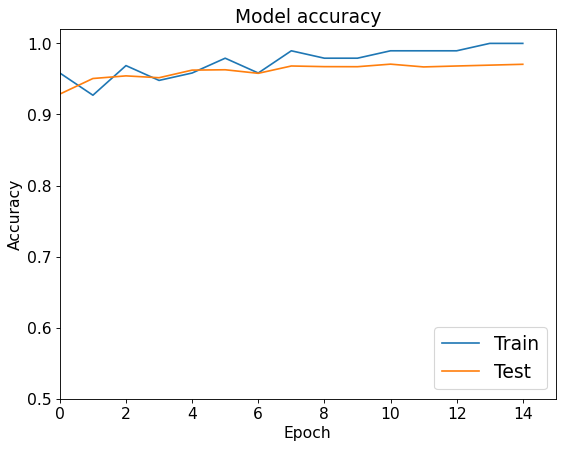

In [28]:
plt.plot([elm['accuracy'] for elm in history])
plt.plot([elm['test_accuracy'] for elm in history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlim([0, 15])
plt.ylim([0.5, 1.02])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig("mnist_shuffle_r18_shuffled_accuracy.svg", format="svg")
plt.show()

In [29]:
history=history[1:]

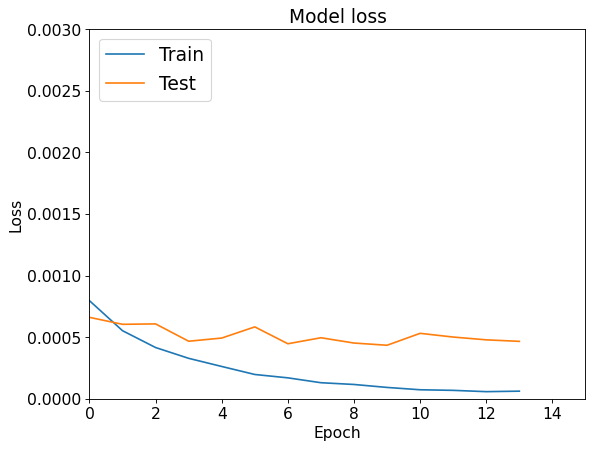

In [31]:
# Plot training & validation loss values
plt.plot([elm['loss'] for elm in history])
plt.plot([elm['test_loss'] for elm in history])
plt.title('Model loss')
plt.xlim([0, 15])
plt.ylim([0.0, 0.003])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("mnist_shuffle_r18_shuffled_aloss.svg", format="svg")
plt.show()

In [32]:
print(f"The train accuracy was {history[-1]['accuracy']:.3f}")
print(f"The test accuracy was {history[-1]['test_accuracy']:.3f}")

The train accuracy was 1.000
The test accuracy was 0.971
